# PDEFIND Feature Overview

This notebook provides a simple overview of the weak form PDE functionality of PySINDy, following the examples in the PDE-FIND paper (Rudy, Samuel H., Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. "Data-driven discovery of partial differential equations." Science Advances 3, no. 4 (2017): e1602614.)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v0.13.0?filepath=example%2Ffeature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
from scipy.io import loadmat
import pysindy as ps
from sklearn.metrics import mean_squared_error
np.random.seed(100)

# Test PDE functionality on the Kuramoto-Sivashinsky equation
The Kuramoto-Sivashinsky equation is
$u_t = -uu_x - u_{xx} - u_{xxxx}$.

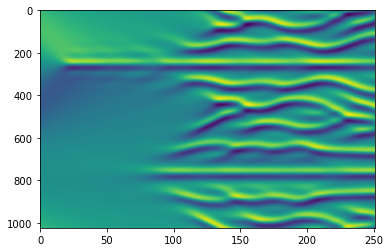

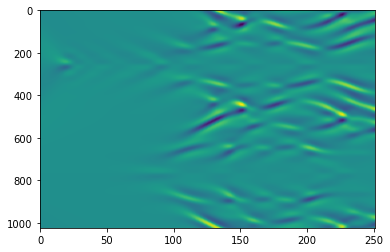

In [5]:
data = loadmat('data/kuramoto_sivishinky.mat')
t = np.ravel(data['tt'])
x = np.ravel(data['x'])
u = data['uu']
dt = t[1] - t[0]
dx = x[1] - x[0]
plt.figure()
plt.imshow(u, aspect='auto')
u_shaped = np.reshape(u, (len(x), len(t), 1))
plt.figure()
ut = np.zeros((len(x), len(t), 1))
for i in range(len(x)):
    ut[i, :, :] = ps.FiniteDifference()._differentiate(u_shaped[i, :, :], t=dt)
plt.imshow(ut, aspect='auto')
print(dt, dx)

# Randomly choose 80% of the time points for training, remaining points for testing, then solve with all the optimizers

In [6]:
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import trapezoid
from pysindy.differentiation import FiniteDifference

train = np.arange(0, int(len(t) * 0.8), dtype=int) #np.random.choice(len(t), int(len(t) * 0.8), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
ut_train = ut[:, train]
ut_test = ut[:, test]
t_train = t[train]
t_test = t[test]

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=3, spatial_grid=x, 
                        temporal_grid=t_train, include_bias=True, 
                        is_uniform=True, weak_form=True, num_pts_per_domain=200)

# Convert ut_train_flattened into a weak form using the pde_lib
K = pde_lib.K
domain_centers = pde_lib.domain_centers
Hx = pde_lib.Hx
Ht = pde_lib.Ht
num_pts_per_domain = pde_lib.num_pts_per_domain
num_time = len(t)
ut_integral = np.zeros((K, 1))
ut_shaped = np.reshape(ut_train, (len(x), len(t_train)))
ut_interp = RectBivariateSpline(x, t_train, ut_shaped)
for k in range(K):
    x1_k = domain_centers[k, 0] - Hx
    x2_k = domain_centers[k, 0] + Hx
    xgrid_k = np.linspace(x1_k, x2_k, num_pts_per_domain)
    t1_k = domain_centers[k, -1] - Ht
    t2_k = domain_centers[k, -1] + Ht
    tgrid_k = np.linspace(t1_k, t2_k, num_pts_per_domain)
    X, T = np.meshgrid(xgrid_k, tgrid_k, indexing='ij')
    X = np.ravel(X)
    T = np.ravel(T)
    u_new = ut_interp.ev(X, T)
    u_new = np.reshape(u_new, (num_pts_per_domain,
                               num_pts_per_domain,
                               1))
    w = pde_lib._smooth_ppoly(
                np.reshape(xgrid_k, (num_pts_per_domain, 1)),
                tgrid_k, k,
            )
    w_diff = FiniteDifference(
                d=1, is_uniform=True)._differentiate(w, tgrid_k)
    ut_integral[k] = (
        trapezoid(
            trapezoid(
                u_new * w_diff, x=xgrid_k, axis=0
            ) * (-1),
            x=tgrid_k, axis=0
        )
    )

In [8]:
optimizer = ps.STLSQ(threshold=1, alpha=0, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_integral)
model.print()

# optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
#                    thresholder='l0', normalize_columns=True)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train_flattened, x_dot=ut_train_flattened)
# model.print()

# optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15, 
#                    thresholder='l1', normalize_columns=True)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train_flattened, x_dot=ut_train_flattened)
# model.print()

# optimizer = ps.SSR(normalize_columns=True, L0_penalty=1e-3)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train_flattened, x_dot=ut_train_flattened)
# model.print()

# optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, L0_penalty=1e-3)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train_flattened, x_dot=ut_train_flattened)
# model.print()

# optimizer = ps.FROLS(normalize_columns=True, L0_penalty=1e-4)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train_flattened, x_dot=ut_train_flattened)
# model.print()

x0' = -0.331 1 + 0.021 x0 + 0.048 x0x0 + -0.045 x0_11 + -0.086 x0_111 + -22677.086 x0x0_1 + -14581.675 x0x0x0_1 + 22677.353 x0x0_11 + 14581.777 x0x0x0_11 + -26.992 x0x0_111 + -17.328 x0x0x0_111
